In [1]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import math as m

In [0]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
train_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv').set_index('id')
test_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').set_index('id')

### 분석 방법

1. Y00 - Y17 4300개의 데이터로 각 feature 430개의 값을 예측 
    - Y18 값과 유사한 feature 찾기
    - Y06,Y09,Y12,Y16이 Y18과의 mse값이 낮고, 상관도가 높다.

2. Y06,Y09,Y12,Y16의 조합으로 진짜 Y18을 예측
    - mse가 가장 낮은 조합을 사용

3.  Y_train 값 설정
  - 2번의 조합 + 기존의 Y18로 나머지 test 예측
  - 2번의 조합에서 각각의 Y로 80일 예측 후 평균

4. feature 공학

In [0]:
def predict_test(X_train, y_train, X_test):

  lgb_train = lgb.Dataset(X_train, label=y_train)

  lgb_param = {
      "objective":"regression",
      "metrics":"mae",
      "learning_rate":0.05
  }

  print("cv start")
  cv_result = lgb.cv(
      lgb_param,
      lgb_train,
      num_boost_round=99999,
      nfold=5,
      early_stopping_rounds=100,
      stratified=False,
      verbose_eval=10 
  )

  print("train start")
  lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l1-mean"])
  )

  pred = lgb_model.predict(X_test)

  feature_importance = pd.DataFrame({'name' : lgb_model.feature_name(),
                                   'importance' : lgb_model.feature_importance()})\
                                   .sort_values(by = 'importance', ascending = False)
  
  return pred, feature_importance

In [0]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, ['Y06', 'Y09', 'Y12']].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

In [6]:
# data_processing_lst = []
# data_processing_lst 불러오기
data_processing_lst = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing_lst.csv').values.tolist()
data_processing_lst

[['Drop_0_value_and_daily_cumulative_precipitation_Mean_Sectioning_daily_cumulative_precipitation',
  2641.6659508828625],
 ['All_feature_MinMaxScaler', 2913.177659654833],
 ['Drop_14_16_19_daily_Sectioning_daily_cumulative_precipitation',
  2924.9213625518983],
 ['raw', 2925.955349543083],
 ['All_feature_MaxAbsScaler', 2925.955349543083],
 ['Drop_14_16_19_log_wind_direction', 2926.223458997889],
 ['All_feature_LogScaler', 2926.503154744445],
 ['All_feature_RobustScaler', 2987.5879537738165],
 ['All_feature_StandardScaler', 2991.0399273592907],
 ['Drop_14_16_19_daily_cumulative_precipitation_mean', 3002.134662826032],
 ['Drop_14_16_19_daily_cumulative_precipitation_mean', 3002.134662826032]]

In [0]:
### Best Processing

def data_processing(X_data):
  X_data['X01'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['X22'] = X_data[['X22','X29']].mean(axis = 1)
  X_data['X05'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  X_data['X11'] = X_data[['X11','X34']].mean(axis = 1)
  # 13 삭제 / 14,16,19 0 값 삭제
  X_data = X_data.drop(['X06','X29','X08','X09','X23','X33','X34','X13','X14','X16','X19'], axis = 1)
  return X_data

In [0]:
# from sklearn.preprocessing import FunctionTransformer

# def data_processing1(X_data):
#   # 풍향 North_South / East_West
#   X_data['North_South_X13'] = X['X13'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X13'] = X['X13'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

#   # 누적 일사량 평균
#   X_data['Mean_cumulative_daily_insolation'] = X_data[['X11','X34']].mean(axis = 1)
#   # 풍속 평균
#   X_data['Mean_wind_speed'] = X_data[['X02','X03','X18','X24','X26']].mean(axis = 1)
#   # 풍향 평균
#   X_data['Mean_North_South'] = X_data[['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35']].mean(axis = 1)
#   X_data['Mean_East_West'] = X_data[['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35']].mean(axis = 1)

#   # 풍향 * 풍속
#   # X_data['North_South_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']
#   # X_data['East_West_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']

#   # 현지 기압 삭제
#   X_data = X_data.drop(['X01','X06','X22','X27','X29'], axis = 1)
#   # 풍속 삭제
#   X_data = X_data.drop(['X02','X03','X18','X24','X26'], axis = 1)
#   # 누적 강수량 삭제
#   X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)
#   # 해면 기압 삭제
#   X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
#   # 누적 일사량 삭제
#   X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)
#   # 풍향 삭제
#   X_data = X_data.drop(['X13','X15','X17','X25','X35'], axis = 1)
#   X_data = X_data.drop(['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35'], axis = 1)
#   X_data = X_data.drop(['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35'], axis = 1)

#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

In [150]:
from sklearn.preprocessing import FunctionTransformer

def data_processing1(X_data):
  # 풍향 North_South / East_West
  X_data['North_South_X13'] = X['X13'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X13'] = X['X13'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

  # 누적 일사량 평균
  X_data['Mean_cumulative_daily_insolation'] = X_data[['X11','X34']].mean(axis = 1)
  # 풍속 평균
  X_data['Mean_wind_speed'] = X_data[['X02','X03','X18','X24','X26']].mean(axis = 1)
  # 풍향 평균
  X_data['Mean_North_South'] = X_data[['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35']].mean(axis = 1)
  X_data['Mean_East_West'] = X_data[['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35']].mean(axis = 1)

  # 풍향 * 풍속
  # X_data['North_South_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']
  # X_data['East_West_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']

  # 현지 기압 삭제
  X_data = X_data.drop(['X01','X06','X22','X27','X29'], axis = 1)
  # 풍속 삭제
  X_data = X_data.drop(['X02','X03','X18','X24','X26'], axis = 1)
  # 누적 강수량 삭제
  X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)
  # 해면 기압 삭제
  X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
  # 누적 일사량 삭제
  X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)
  # 풍향 삭제
  X_data = X_data.drop(['X13','X15','X17','X25','X35'], axis = 1)
  X_data = X_data.drop(['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35'], axis = 1)
  X_data = X_data.drop(['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35'], axis = 1)

  return X_data

new_X = data_processing(X.copy())
X_train = new_X.iloc[:4320, :40]
X_test = new_X.iloc[4320:, :40]
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

cv start
[10]	cv_agg's l1: 4.33799 + 0.0433878
[20]	cv_agg's l1: 2.7369 + 0.0286553
[30]	cv_agg's l1: 1.81284 + 0.02047
[40]	cv_agg's l1: 1.30015 + 0.0163477
[50]	cv_agg's l1: 1.01601 + 0.0197243
[60]	cv_agg's l1: 0.862863 + 0.0202946
[70]	cv_agg's l1: 0.775856 + 0.0197703
[80]	cv_agg's l1: 0.721145 + 0.0164031
[90]	cv_agg's l1: 0.684213 + 0.0151915
[100]	cv_agg's l1: 0.65629 + 0.0157533
[110]	cv_agg's l1: 0.635641 + 0.0152549
[120]	cv_agg's l1: 0.620654 + 0.0140487
[130]	cv_agg's l1: 0.608047 + 0.0136825
[140]	cv_agg's l1: 0.597237 + 0.0124665
[150]	cv_agg's l1: 0.587797 + 0.0123866
[160]	cv_agg's l1: 0.580339 + 0.0124906
[170]	cv_agg's l1: 0.573761 + 0.0121099
[180]	cv_agg's l1: 0.566865 + 0.0119986
[190]	cv_agg's l1: 0.560874 + 0.0119106
[200]	cv_agg's l1: 0.555697 + 0.0119953
[210]	cv_agg's l1: 0.551172 + 0.0117826
[220]	cv_agg's l1: 0.546526 + 0.0122098
[230]	cv_agg's l1: 0.542249 + 0.0118709
[240]	cv_agg's l1: 0.5379 + 0.0123137
[250]	cv_agg's l1: 0.534448 + 0.0124953
[260]	cv_ag

2851.5675896894168
   name  importance
10  X15        8701
24  X35        8651
9   X12        8418
21  X30        8200
11  X17        6991
13  X20        6683
26  X37        6620
23  X32        6389
3   X03        6332
22  X31        6148
2   X02        6132
12  X18        6068
27  X38        6033
0   X00        5881
8   X11        5671
20  X28        5439
6   X07        5378
18  X26        5111
17  X25        4928
1   X01        4273
16  X24        3673
5   X05        3154
19  X27        2996
15  X22        2800
28  X39         228
7   X10         131
25  X36         119
4   X04          99
14  X21          83


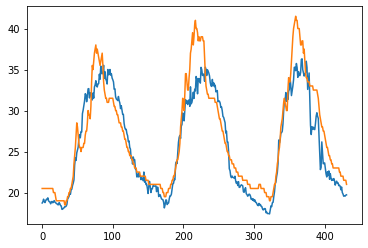

In [152]:
Y_test.index = range(len(Y_pred))
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
# data_processing_lst.append(['Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___Mean_wind_speed___wind_direction___North_South___East_West___Mean_cumulative_daily_insolation___wind_speed___North_South___East_West___Processing_wind_direction___wind_direction*wind_speed',mse])
print(mse)
print(feature_importance)

In [139]:
result = pd.DataFrame(data_processing_lst, columns = ['name','mse']).set_index('name').sort_values('mse')
result.to_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing_lst.csv')
result.head(15)

,mse
name,
Drop___daily_cumulative_precipitation__local_air_pressure___barometric_pressure___cumulative_daily_insolation___Mean_cumulative_daily_insolation,2101.885989
Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___wind_direction___Mean_cumulative_daily_insolation___wind_speed___Processing_wind_direction,2126.949761
Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___wind_direction___Mean_cumulative_daily_insolation___wind_speed___Processing_wind_direction_13_15_17_35,2130.876254
Drop___daily_cumulative_precipitation__local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___Mean_cumulative_daily_insolation___wind_speed,2135.743576
Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___wind_direction___Mean_cumulative_daily_insolation___wind_speed___Processing_Mean_wind_direction,2143.883932
Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___wind_direction___Mean_cumulative_daily_insolation___wind_speed___Processing_wind_direction___Mean_Processing_wind_direction,2153.980014
Drop_0_value___daily_cumulative_precipitation__local_air_pressure___barometric_pressure,2159.036850
Drop_0_value___daily_cumulative_precipitation__local_air_pressure___barometric_pressure___Mean_barometric_pressure,2159.036850
Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___wind_direction___Mean_cumulative_daily_insolation___wind_speed___temperatures___Processing_wind_direction,2169.470482


In [157]:
X_train = data_processing1(X.copy())
len(X_train)

4752

In [158]:
# 4300개의 예측값(12,16 평균) + Y_의 실제값
before = train_dt[['Y06','Y09','Y12']].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

Y_train = pd.concat([before, after],ignore_index=True)

len(Y_train)

4752

In [159]:
X_test = data_processing1(test_dt.copy())
len(X_test)

11520

In [160]:
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

cv start
[10]	cv_agg's l1: 4.2774 + 0.0703918
[20]	cv_agg's l1: 2.72332 + 0.0651469
[30]	cv_agg's l1: 1.8464 + 0.0454719
[40]	cv_agg's l1: 1.36059 + 0.0333925
[50]	cv_agg's l1: 1.09294 + 0.0340946
[60]	cv_agg's l1: 0.947546 + 0.0323272
[70]	cv_agg's l1: 0.867931 + 0.031871
[80]	cv_agg's l1: 0.818984 + 0.0284163
[90]	cv_agg's l1: 0.788572 + 0.0268334
[100]	cv_agg's l1: 0.765775 + 0.0253025
[110]	cv_agg's l1: 0.748875 + 0.0259426
[120]	cv_agg's l1: 0.733722 + 0.0245282
[130]	cv_agg's l1: 0.720601 + 0.024141
[140]	cv_agg's l1: 0.708766 + 0.0240099
[150]	cv_agg's l1: 0.699508 + 0.0235794
[160]	cv_agg's l1: 0.690365 + 0.0227678
[170]	cv_agg's l1: 0.682392 + 0.022937
[180]	cv_agg's l1: 0.675221 + 0.0225763
[190]	cv_agg's l1: 0.668018 + 0.0218578
[200]	cv_agg's l1: 0.661503 + 0.0222285
[210]	cv_agg's l1: 0.655917 + 0.0222202
[220]	cv_agg's l1: 0.651145 + 0.0216646
[230]	cv_agg's l1: 0.645642 + 0.0218841
[240]	cv_agg's l1: 0.640849 + 0.0215614
[250]	cv_agg's l1: 0.635522 + 0.0207715
[260]	cv_a

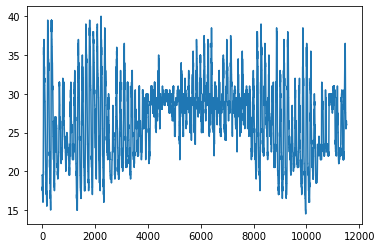

In [161]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')